In [1]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import pandas as pd

In [2]:
df = pd.read_csv("obat_alodokter_new.csv")
df.head()
df_obat_for_eval = df.drop(['nama_obat'],axis=1)

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\n+', ' ', text)  # hapus banyak \n
    text = re.sub(r'\s+', ' ', text)   # hapus spasi berlebihan
    return text.strip()

df['cleaned_reference'] = df['content'].apply(clean_text)

df['generated_text'] = df['cleaned_reference'].apply(lambda x: x.lower())

In [4]:
df_obat_for_bleu = df.drop(['nama_obat','generated_text','content'],axis=1)
df_obat_for_ndcg = df.drop(['generated_text','content'],axis=1)

In [5]:
df_obat_for_bleu

,cleaned_reference
0,Zyloric Zyloric adalah obat untuk menurunkan k...
1,Zovirax Krim Zovirax krim adalah obat oles yan...
2,Zovigen Zovigen adalah obat oles yang bermanfa...
3,Zoralin Krim Zoralin krim adalah obat oles unt...
4,Zoralin Zoralin adalah tablet antijamur berbah...
...,...
2168,Acarbose Acarbose adalah obat untuk menurunkan...
2169,Acalabrutinib Acalabrutinib adalah obat kemote...
2170,Abrocitinib Abrocitinib adalah obat untuk meng...
2171,Abemaciclib Abemaciclib adalah obat kemoterapi...


In [12]:
df_obat_for_ndcg

,nama_obat,cleaned_reference
0,Zyloric,Zyloric Zyloric adalah obat untuk menurunkan k...
1,Zovirax Krim,Zovirax Krim Zovirax krim adalah obat oles yan...
2,Zovigen,Zovigen Zovigen adalah obat oles yang bermanfa...
3,Zoralin Krim,Zoralin Krim Zoralin krim adalah obat oles unt...
4,Zoralin,Zoralin Zoralin adalah tablet antijamur berbah...
...,...,...
2168,Acarbose,Acarbose Acarbose adalah obat untuk menurunkan...
2169,Acalabrutinib,Acalabrutinib Acalabrutinib adalah obat kemote...
2170,Abrocitinib,Abrocitinib Abrocitinib adalah obat untuk meng...
2171,Abemaciclib,Abemaciclib Abemaciclib adalah obat kemoterapi...


In [6]:
import pandas as pd
import json

def format_result_to_text(user_data):
    formatted_text = ""
    for idx, record in enumerate(user_data['agent']):
        nomor = idx + 1  
        formatted_text += f"{nomor}. Rekomendasi obat:\n"
        formatted_text += f" - {record.get('nama_obat')} Dosis: {record.get('dosis')}\n"
        formatted_text += f"   Aturan pakai: {record.get('aturan_pakai', 'Aturan Pakai Tidak Tersedia')}\n"
        formatted_text += f"   Efek samping: {record.get('efek_samping_obat', 'Efek Samping Tidak Tersedia')}\n\n"
    return formatted_text.strip()

with open('memory.json', 'r') as file:
    data = json.load(file)

df_obat_for_bleu = pd.DataFrame({
    'generated_text': [None] * 4 
})

user_id = "7116300622"
if user_id in data:
    user_data = data[user_id][0] 
    formatted_text = format_result_to_text(user_data)
    
    df_obat_for_bleu.loc[0, 'generated_text'] = formatted_text


In [7]:
bleu_scores = []
rouge_scores = []

rouge = Rouge()

In [8]:
for idx, row in df.iterrows():
    reference = [row['cleaned_reference'].split()]  # list of list
    candidate = row['generated_text'].split()

    # Hitung BLEU
    bleu = sentence_bleu(reference, candidate)
    bleu_scores.append(bleu)

    # Hitung ROUGE
    rouge_score = rouge.get_scores(row['generated_text'], row['cleaned_reference'])[0]
    rouge_scores.append(rouge_score)

# Rata-rata skor
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge_1 = sum([r['rouge-1']['f'] for r in rouge_scores]) / len(rouge_scores)
avg_rouge_2 = sum([r['rouge-2']['f'] for r in rouge_scores]) / len(rouge_scores)
avg_rouge_l = sum([r['rouge-l']['f'] for r in rouge_scores]) / len(rouge_scores)

print("Average BLEU:", avg_bleu)
print("Average ROUGE-1:", avg_rouge_1)
print("Average ROUGE-2:", avg_rouge_2)
print("Average ROUGE-L:", avg_rouge_l)

Average BLEU: 0.6563175584020436
Average ROUGE-1: 0.8320645836767182
Average ROUGE-2: 0.710628568721906
Average ROUGE-L: 0.8320645836767182


In [19]:
import pandas as pd
import json
import math

list_obat = df_obat_for_ndcg['nama_obat'].tolist()

with open("memory.json", "r", encoding="utf-8") as f:
    data = json.load(f)

def map_penyakit_ke_obat(df_obat, penyakit):
    matched_obat = []
    for _, row in df_obat.iterrows():
        if isinstance(row['cleaned_reference'], str) and penyakit.lower() in row['cleaned_reference'].lower():
            matched_obat.append(row['nama_obat'])
    return matched_obat

def compute_ndcg_at_k(true_relevant, recommended_items, k):
    def dcg(relevances):
        return sum((1 / math.log2(i + 2)) for i, rel in enumerate(relevances) if rel > 0)
    
    relevance_scores = [1 if item in true_relevant else 0 for item in recommended_items[:k]]
    ideal_relevance = sorted(relevance_scores, reverse=True)

    dcg_score = dcg(relevance_scores)
    idcg_score = dcg(ideal_relevance)
    return dcg_score / idcg_score if idcg_score != 0 else 0.0

for user_id, entries in data.items():
    if user_id in ["started_users", "history_backup"]:
        continue

    for entry in entries:
        user_input = entry.get("user", "")
        agent_outputs = entry.get("agent", [])

        # List untuk penyakit yang terdeteksi dan rekomendasi obat
        penyakit_list = []
        recommended_items = []

        for agent in agent_outputs:
            nama_penyakit = agent.get("nama_penyakit", "")
            rekom_obat = agent.get("nama_obat", "")

            if nama_penyakit:
                penyakit_list.append(nama_penyakit)

            if rekom_obat and "belum ada" not in rekom_obat.lower():
                recommended_items.append(rekom_obat)

        # TRUE RELEVANT: semua obat yang cocok dengan penyakit
        true_relevant = []
        for penyakit in penyakit_list:
            true_relevant.extend(map_penyakit_ke_obat(df_obat_for_ndcg, penyakit))

        # Hapus duplikat kalau ada
        true_relevant = list(set(true_relevant))

        # Hitung skor NDCG@5
        ndcg_score = compute_ndcg_at_k(true_relevant, recommended_items, k=5)

        # Tampilkan hasil untuk setiap user dan setiap penyakit
        print(f"User ID: {user_id}")
        print(f"User Input: {user_input}")
        print(f"Penyakit Terdeteksi: {penyakit_list}")
        print(f"Recommended Obat: {recommended_items}")
        print(f"True Relevant Obat: {true_relevant}")
        print(f"NDCG@5: {ndcg_score:.4f}\n")

User ID: 7116300622
User Input: Gejala saya pusing dan mual
Penyakit Terdeteksi: ['Migraines', 'Vestibular Disorders (e.g., Benign Paroxysmal Positional Vertigo)', 'Inner Ear Infections (Labyrinthitis)', 'Anxiety and Panic Disorders', 'Gastroenteritis (Stomach Flu)', 'Low Blood Pressure (Hypotension)', 'Cardiovascular Issues (e.g., Arrhythmias)']
Recommended Obat: ['Sumatriptan', 'Meclizine', 'Antihistamin (misalnya, Dimenhydrinate)', 'Sertraline', 'Loperamide', 'Fludrocortisone', 'Beta-blockers (misalnya, Metoprolol)']
True Relevant Obat: []
NDCG@5: 0.0000

User ID: 7116300622
User Input: Gejala saya batuk berdahak dan pilek
Penyakit Terdeteksi: ['Common Cold (Pilek Biasa)', 'Influenza (Flu)']
Recommended Obat: ['Paracetamol', 'Oseltamivir (Tamiflu)']
True Relevant Obat: []
NDCG@5: 0.0000



In [21]:
def f1_score_rag(pred, true):
    pred_tokens = pred.lower().split()
    true_tokens = true.lower().split()

    common = set(pred_tokens) & set(true_tokens)
    if not common:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

generated_answer = 'Modafinil diambil sesuai dosis yang diresepkan dokter tergantung kondisi pasien. Pastikan untuk mengikuti instruksi serta waktu dan cara penggunaan yang tepat.'
ground_truth_answer = 'Dosis modafinil yang diresepkan dokter dapat berbeda pada tiap pasien. Berikut ini adalah dosis umum penggunaan modafinil berdasarkan kondisi pasien'

f1_score = f1_score_rag(generated_answer, ground_truth_answer)

print("F1 Score:",f1_score)

F1 Score: 0.3902439024390244


In [22]:
scores = {
    "Bleu" : avg_bleu,
    "Rouge-1" : avg_rouge_1,
    "Rouge-2" : avg_rouge_2,
    "Rouge-L" : avg_rouge_l,
    "F1-Score" : f1_score,
    "NDCG" : ndcg_score
}

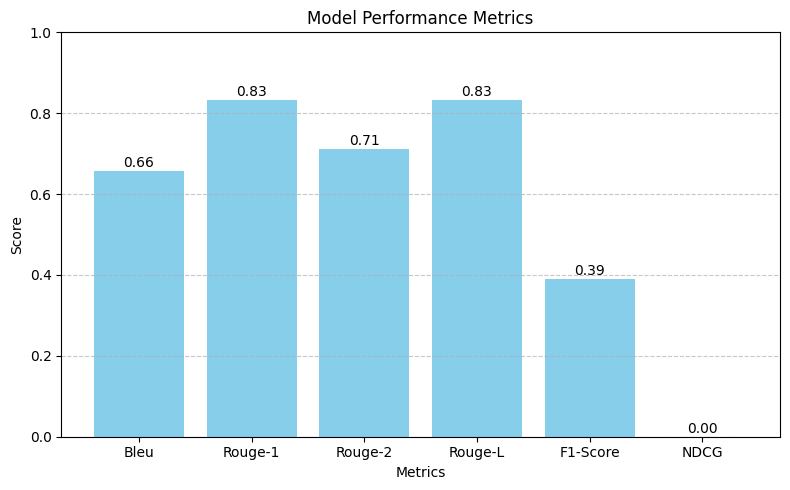

In [23]:
import matplotlib.pyplot as plt

# Data
metrics = list(scores.keys())
values = list(scores.values())

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color='skyblue')

# Tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

# Label dan judul
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
